In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import sys  
sys.path.insert(0, '../../..')

from hnn.simulation.mve_ensemble import MveEnsembleHamiltonianDynamics
from hnn.utils import integrate_model
from hnn.train import train
from hnn.types import TrajectoryArgs

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=300, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=1000, type=int, help='number of gradient steps')
    parser.add_argument('--field_type', default='conservative', type=str, help='type of vector field to learn') # solenoidal, conservative
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

In [3]:
from hnn.simulation.mve_ensemble.mve_ensemble import mve_ensemble_fn, get_initial_conditions

coords, masses = get_initial_conditions(3)

# Hamiltonian for the ensemble
H = mve_ensemble_fn(coords, masses)
print("Hamiltonian (Total Energy):", H.item())

Hamiltonian (Total Energy): 4.420302867889404


In [5]:
N_BODIES = 6
hamiltonian = MveEnsembleHamiltonianDynamics(n_bodies=N_BODIES)
pos, mom, dc, dv, time = hamiltonian.get_trajectory({})
positions = pos.transpose(0, 1)
momentums = mom.transpose(0, 1)
num_timepoints = len(time)

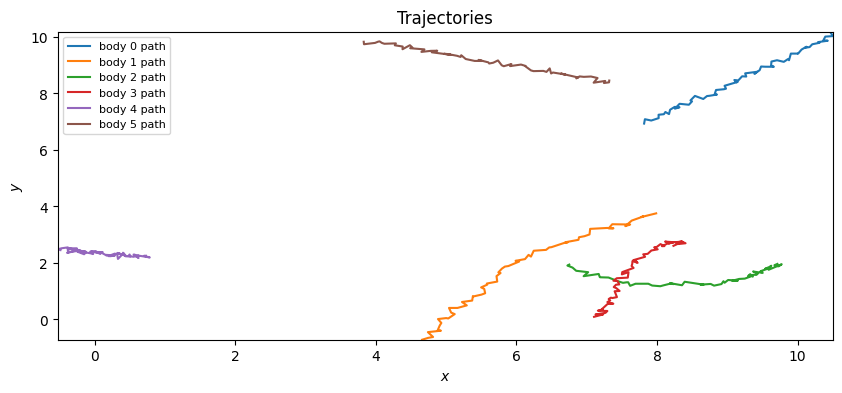

In [6]:
fig, ax = plt.subplots(figsize=[10, 4], dpi=100)
ax.set_title('Trajectories')
lines = []
for i in range(positions.shape[0]):
    line, = ax.plot([], [], label='body {} path'.format(i))
    lines.append(line)

xmin, xmax = torch.min(positions[:,:,0]), torch.max(positions[:,:,0])
ymin, ymax = torch.min(positions[:,:,1]), torch.max(positions[:,:,1])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(fontsize=8)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    for i, line in enumerate(lines):
        x, y = positions[i, :frame, 0], positions[i, :frame, 1]
        line.set_data(x, y)
    return lines

ani = FuncAnimation(fig, update, frames=torch.arange(1, num_timepoints+1), init_func=init, blit=True, repeat=False)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
from hnn.simulation.mve_ensemble.mve_ensemble import calc_lennard_jones_potential, calc_kinetic_energy
ljp = calc_lennard_jones_potential(positions)
masses = torch.ones(N_BODIES)
ke = calc_kinetic_energy(momentums, masses)
te = ljp + ke

fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(time, ljp, label='potential')
plt.plot(time, ke, label='kinetic')
plt.plot(time, te, label='total')
plt.legend(fontsize=8)


In [ ]:
args = get_args()

# data = hamiltonian.get_dataset({}, {})
# model, stats = train(args, data)